In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from xgboost import XGBClassifier

import pickle # to save and load pre-trained models

In [2]:
%matplotlib inline

In [3]:
#trades_df = pd.read_csv('buy_signals_backtest_ML_July-Aug2020.dat')
trades_df = pd.read_csv('buy_signals_backtest_ML_Jan2019-Aug2020.dat')
#trades_df.set_index('time_curr', inplace=True)
#trades_df.index=pd.to_datetime(trades_df.index)

In [4]:
trades_df.columns

Index(['time_curr', 'symbol', 'price', 'pattern', 'origin', 'ranging',
       'd_ranging', 'lower', 'upper', 'middle', 'd_lower', 'd_upper',
       'd_middle', 'ema_10', 'ema_200', 'd_ema_10', 'd_ema_200', 'k_15',
       'd_15', 'd_k_15', 'd_d_15', 'stoch_cond_5', 'candle_color', 'vol_inc',
       'dist_to_BB', 'profit', 'elapsed', 'min_price', 'max_price',
       'profit_s15', 'elapsed_s15', 'min_price_s15', 'max_price_s15',
       'Unnamed: 33'],
      dtype='object')

In [5]:
profitability = [0 if item < 0 else 1 for item in trades_df['profit']]
trades_df['profitability'] = profitability
profitability_s15 = [0 if item < 0 else 1 for item in trades_df['profit_s15']]
trades_df['profitability_s15'] = profitability_s15


Convert 'time_curr' to `datetime` object

In [6]:
trades_df['time_curr'] = pd.to_datetime(trades_df['time_curr'])

In [7]:
# Sort the dataframe by the date:
trades_df.sort_values(by=['time_curr'], inplace=True)

In [8]:
trades_df.columns

Index(['time_curr', 'symbol', 'price', 'pattern', 'origin', 'ranging',
       'd_ranging', 'lower', 'upper', 'middle', 'd_lower', 'd_upper',
       'd_middle', 'ema_10', 'ema_200', 'd_ema_10', 'd_ema_200', 'k_15',
       'd_15', 'd_k_15', 'd_d_15', 'stoch_cond_5', 'candle_color', 'vol_inc',
       'dist_to_BB', 'profit', 'elapsed', 'min_price', 'max_price',
       'profit_s15', 'elapsed_s15', 'min_price_s15', 'max_price_s15',
       'Unnamed: 33', 'profitability', 'profitability_s15'],
      dtype='object')

In [9]:
time_span = trades_df.time_curr.iloc[-1] - trades_df.time_curr.iloc[0]
print(f"Total profitability in {time_span}: ", trades_df['profitability'].sum()/len(trades_df['profitability']) )
print("total n trades: ", len(trades_df['profitability']))
print(f"Total profitability in {time_span} with 0.15 stop loss: ", trades_df['profitability_s15'].sum()/len(trades_df['profitability_s15']) )
print("total n trades: ", len(trades_df['profitability_s15']))

Total profitability in 617 days 10:45:00:  0.6138994161630646
total n trades:  39052
Total profitability in 617 days 10:45:00 with 0.15 stop loss:  0.4338318139916009
total n trades:  39052


In [10]:
trades_df['profitability']

23015    1
23016    1
23017    1
14973    0
22340    1
        ..
9339     1
9340     1
2661     1
10106    1
3250     1
Name: profitability, Length: 39052, dtype: int64

In [11]:
pd.set_option('max_columns',100)

In [12]:
trades_df.dropna(axis=1, inplace=True)
#trades_df.fillna(0.0, inplace=True)

In [13]:
# Remove the problematic coin that has been identified later
#trades_df = trades_df[trades_df.symbol != 'UMABTC']

In [14]:
trades_df.head()

,time_curr,symbol,price,pattern,origin,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,d_ema_10,k_15,d_15,d_k_15,d_d_15,stoch_cond_5,candle_color,vol_inc,dist_to_BB,profit,elapsed,min_price,max_price,profit_s15,elapsed_s15,min_price_s15,max_price_s15,profitability,profitability_s15
23015,2019-01-02 01:15:00,BCPTBTC,0.000009,no,lower,5.248,0.022,0.000009,0.000009,0.000009,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,14.66,7.33,0.49,0.15,True,green,0.290,2.422,1.5,386.0,-1.45,1.79,-1.5,326.0,-1.25,1.12,1,0
23016,2019-01-02 01:30:00,BCPTBTC,0.000009,Doji,lower,5.210,-0.003,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,21.98,14.66,0.49,0.49,True,green,0.541,2.243,1.5,371.0,-1.45,1.79,-1.5,311.0,-1.25,0.45,1,0
23017,2019-01-02 02:15:00,BCPTBTC,0.000009,Bullish eng.,lower,5.461,-0.013,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,19.87,16.34,0.29,0.00,True,green,0.093,1.713,1.5,325.0,-1.34,1.90,-1.5,266.0,-1.25,0.56,1,0
14973,2019-01-02 19:15:00,OMGBTC,0.000389,Doji,upper,4.002,-0.008,0.000380,0.000395,0.000387,3.000000e-08,1.000000e-08,2.000000e-08,0.000389,2.000000e-08,16.27,12.60,0.23,0.02,True,green,0.180,1.602,-3.0,925.0,-2.50,0.77,-1.5,15.0,-1.25,0.26,0,0
22340,2019-01-02 23:32:00,DLTBTC,0.000015,no,upper,10.349,-0.143,0.000013,0.000015,0.000014,2.000000e-08,-1.000000e-08,0.000000e+00,0.000014,-0.000000e+00,21.39,9.78,1.38,0.20,True,red,1.453,3.859,1.5,10.0,-0.69,0.48,1.5,10.0,-0.69,0.48,1,1


### Now we start preparing the dataset to train a model using various Machine Learning methods

1. Features:

In [15]:
X = trades_df.drop(['symbol','profit',
       'elapsed', 'min_price', 'max_price', 'profit_s15', 'elapsed_s15',
       'min_price_s15', 'max_price_s15',  'profitability',
       'profitability_s15'], axis=1)

# For the 1st trial, let us also drop all categorical variables:
# X = trades_df.drop(['time_curr','profit',
#                     'pattern','origin','symbol','stoch_cond_5','candle_color',
#        'elapsed', 'min_price', 'max_price', 'profit_s15', 'elapsed_s15',
#        'min_price_s15', 'max_price_s15',  'profitability',
#        'profitability_s15'], axis=1)

In [16]:
X['stoch_cond_5'] = X['stoch_cond_5'].astype('str')

In [17]:
X['day'] = X.time_curr.dt.day.astype('uint8')
X['hour'] = X.time_curr.dt.hour.astype('uint8')
X['minute'] = X.time_curr.dt.minute.astype('uint8')

In [18]:
X.drop(['time_curr'], axis=1, inplace=True)

In [19]:
X.columns

Index(['price', 'pattern', 'origin', 'ranging', 'd_ranging', 'lower', 'upper',
       'middle', 'd_lower', 'd_upper', 'd_middle', 'ema_10', 'd_ema_10',
       'k_15', 'd_15', 'd_k_15', 'd_d_15', 'stoch_cond_5', 'candle_color',
       'vol_inc', 'dist_to_BB', 'day', 'hour', 'minute'],
      dtype='object')

In [20]:
# Let's try to drop all prices and keep only the slopes and percentages: (No!)
## X = X.drop(['price', 'lower', 'upper', 'middle', 'ema_10'], axis=1)

In [21]:
###for col in ['d_lower', 'd_upper', 'd_middle', 'd_ema_10' ]: X[col] = X[col]*1e7

In [22]:
X.head()

,price,pattern,origin,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,d_ema_10,k_15,d_15,d_k_15,d_d_15,stoch_cond_5,candle_color,vol_inc,dist_to_BB,day,hour,minute
23015,0.000009,no,lower,5.248,0.022,0.000009,0.000009,0.000009,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,14.66,7.33,0.49,0.15,True,green,0.290,2.422,2,1,15
23016,0.000009,Doji,lower,5.210,-0.003,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,21.98,14.66,0.49,0.49,True,green,0.541,2.243,2,1,30
23017,0.000009,Bullish eng.,lower,5.461,-0.013,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,19.87,16.34,0.29,0.00,True,green,0.093,1.713,2,2,15
14973,0.000389,Doji,upper,4.002,-0.008,0.000380,0.000395,0.000387,3.000000e-08,1.000000e-08,2.000000e-08,0.000389,2.000000e-08,16.27,12.60,0.23,0.02,True,green,0.180,1.602,2,19,15
22340,0.000015,no,upper,10.349,-0.143,0.000013,0.000015,0.000014,2.000000e-08,-1.000000e-08,0.000000e+00,0.000014,-0.000000e+00,21.39,9.78,1.38,0.20,True,red,1.453,3.859,2,23,32


2. Target:

Here we predict whether the trade is going to be profitable or not.

In [23]:
y = trades_df.profitability_s15
# what if we predict profitability for stop loss 0.3?
#y = trades_df.profitability

In [24]:
y

23015    0
23016    0
23017    0
14973    0
22340    1
        ..
9339     1
9340     1
2661     1
10106    1
3250     1
Name: profitability_s15, Length: 39052, dtype: int64

In [25]:
#test_size = 2000

# Make sure that there are no new symbols in the test dataset

# for item_val in X.symbol.tail(test_size).unique():
#     if item_val not in X.symbol.iloc[:-test_size].unique(): print(item_val)

    
    

In [26]:
# X = X[X.symbol != 'UMABTC']
# y = y[X.symbol != 'UMABTC']

In [27]:

# for item_val in X.symbol.tail(test_size).unique():
#     if item_val not in X.symbol.iloc[:-test_size].unique(): print(item_val)

 

### Train and test split

In [28]:
# Random split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=101)

# More realistic split is where we choose the latest deals as test data. Remove last rows:
test_size = 2000
# Remove last rows from the dataset
X_train, y_train = X.iloc[:-test_size], y.iloc[:-test_size]
X_val, y_val = X.tail(test_size), y.tail(test_size)

### Categorical encoding

3. Now it's time to make cathegorical encodings (or wait, let's do it later!) :-)

In [29]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

In [30]:
# categorical = ['pattern', 'origin', 'stoch_cond_5', 'candle_color']
# label = ['symbol']

In [31]:
# for col in label:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_val[col] = label_encoder.transform(X_val[col])

In [32]:
# For now go with the simplest One-Hot encoding provided by pandas:
X_train, X_val = pd.get_dummies(X_train), pd.get_dummies(X_val)

In [33]:
#X_train, X_val = preprocessing.scale(X_train), preprocessing.scale(X_val)

In [34]:
X_train

,price,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,d_ema_10,k_15,d_15,d_k_15,d_d_15,vol_inc,dist_to_BB,day,hour,minute,pattern_Bullish eng.,pattern_Doji,pattern_Hammer,pattern_Harami,pattern_no,origin_lower,origin_upper,stoch_cond_5_False,stoch_cond_5_True,candle_color_green,candle_color_red
23015,0.000009,5.248,0.022,0.000009,0.000009,0.000009,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,14.66,7.33,0.49,0.15,0.290,2.422,2,1,15,0,0,0,0,1,1,0,0,1,1,0
23016,0.000009,5.210,-0.003,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,21.98,14.66,0.49,0.49,0.541,2.243,2,1,30,0,1,0,0,0,1,0,0,1,1,0
23017,0.000009,5.461,-0.013,0.000009,0.000009,0.000009,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000009,-0.000000e+00,19.87,16.34,0.29,0.00,0.093,1.713,2,2,15,1,0,0,0,0,1,0,0,1,1,0
14973,0.000389,4.002,-0.008,0.000380,0.000395,0.000387,3.000000e-08,1.000000e-08,2.000000e-08,0.000389,2.000000e-08,16.27,12.60,0.23,0.02,0.180,1.602,2,19,15,0,1,0,0,0,0,1,0,1,1,0
22340,0.000015,10.349,-0.143,0.000013,0.000015,0.000014,2.000000e-08,-1.000000e-08,0.000000e+00,0.000014,-0.000000e+00,21.39,9.78,1.38,0.20,1.453,3.859,2,23,32,0,0,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,0.000003,4.482,0.015,0.000003,0.000003,0.000003,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000003,-0.000000e+00,12.72,8.40,0.29,0.25,0.183,1.634,1,6,47,0,1,0,0,0,1,0,0,1,1,0
4881,0.000003,4.069,0.019,0.000003,0.000003,0.000003,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000003,-0.000000e+00,28.70,17.33,0.63,0.15,0.726,2.717,1,6,57,0,0,0,0,1,1,0,1,0,1,0
7095,0.000338,4.252,0.021,0.000336,0.000350,0.000343,-5.000000e-08,0.000000e+00,-2.000000e-08,0.000340,-3.000000e-08,12.10,6.30,0.35,0.27,1.062,1.623,1,7,7,0,0,0,0,1,1,0,1,0,1,0
715,0.000428,4.432,0.020,0.000426,0.000444,0.000435,-1.100000e-07,3.000000e-08,-4.000000e-08,0.000431,-8.000000e-08,10.29,4.24,0.69,0.17,1.172,1.657,1,7,10,0,0,0,0,1,1,0,0,1,1,0


### Define a function to compare different methods

In [55]:
# function for comparing different approaches
def score_dataset(model, X_train, X_val, y_train, y_val, **kwargs):
    '''Trains a model, makes predictions. 
    Prints classification report
    Returns mean absolute error'''
    #Modified from: https://www.kaggle.com/alexisbcook/exercise-categorical-variables
    model.fit(X_train, y_train, **kwargs)
    preds = model.predict(X_val)
    print(classification_report(y_val,preds))
    return mean_absolute_error(y_val, preds)

4. Let's already try some methods:

### Random Forest

In [36]:
random_forest_basic = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1)

In [37]:
print("Random Forest :")
score_dataset(random_forest_basic, X_train, X_val, y_train, y_val)

Random Forest :
              precision    recall  f1-score   support

           0       0.63      0.88      0.74      1179
           1       0.61      0.26      0.36       821

    accuracy                           0.63      2000
   macro avg       0.62      0.57      0.55      2000
weighted avg       0.62      0.63      0.58      2000



0.373

### Logistic regression

In [38]:
logmodel_basic = LogisticRegression(solver='warn')

In [39]:

print("Logistic regression :")
score_dataset(logmodel_basic, X_train, X_val, y_train, y_val)

Logistic regression :


C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.89      0.76      1179
           1       0.68      0.32      0.43       821

    accuracy                           0.66      2000
   macro avg       0.67      0.61      0.59      2000
weighted avg       0.66      0.66      0.62      2000



0.3415

Check feature importance

In [40]:
logmodel_basic.fit(X_train, y_train)

C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
importance = logmodel_basic.coef_[0]

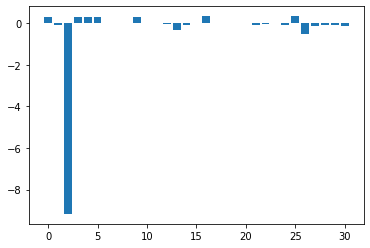

In [42]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [43]:
len(importance)

31

In [44]:
# try different solvers for logostic regression
# solvers = {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
# for solver in solvers:
#     logmodel_solv = LogisticRegression(solver=solver)
#     print(f"Solver : {solver}")
#     score_dataset(logmodel_solv, X_train, X_val, y_train, y_val)

### XG Boost

In [45]:
XGB_basic = XGBClassifier(n_estimators=1000, learning_rate=0.01, random_state=0)

In [46]:
# XGB_basic.fit(X_train, y_train,
#              early_stopping_rounds=5, 
#              eval_set=[(X_val, y_val)], 
#              verbose=False)

In [57]:
print("XG Boost :")
score_dataset(XGB_basic, X_train, X_val, y_train, y_val,
             early_stopping_rounds=10,
             eval_set=[(X_val, y_val)],
             verbose=False)

XG Boost :
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1179
           1       0.60      0.60      0.60       821

    accuracy                           0.67      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.67      0.67      2000



0.331

In [48]:
#val_preds_XGB = XGB_basic.predict(X_val)

In [49]:
#mae = mean_absolute_error(val_preds_XGB, y_val)

In [50]:
#print(f"MAE for the XG Boost without categorical features: {mae}")

### The best model

According to the classification reports, the best model that predicts succesfull trasdes is happened to be logistic regression.
Now, save this model using `pickle`

In [51]:
# let's train the model again:
logmodel_basic = LogisticRegression(solver='warn')
logmodel_basic.fit(X_train, y_train)


C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
## Load pre-trained model:
# with open('logregression.pickle', 'wb') as f:
#     pickle.dump(logmodel_basic, f)

In [53]:
# Open pre-trained model:
pickle_in = open('logregression.pickle', 'rb')
logmodel_loaded = pickle.load(pickle_in)

In [54]:
# Check if loaded model shows the same results:
score_dataset(logmodel_loaded, X_train, X_val, y_train, y_val)

C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.89      0.76      1179
           1       0.68      0.32      0.43       821

    accuracy                           0.66      2000
   macro avg       0.67      0.61      0.59      2000
weighted avg       0.66      0.66      0.62      2000



0.3415

<b> Note. </b> `XGBoost` shows better accuracy in general, but it better predicts loosing trades rather than succesfull. 